In [1]:
import wfdb
import os
import re
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import pyedflib
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
dbs = wfdb.get_dbs()
records_list = wfdb.io.get_record_list('chbmit', records='all')
patient_codes = sorted(list(set([record.split('/')[0] for record in records_list])))

In [3]:
def get_content(patient_code):
    url = "https://physionet.org/physiobank/database/chbmit/" + patient_code + '/' \
            + patient_code + '-summary.txt'
    filename = "./chbmit.txt"
    urlretrieve(url, filename)
    with open(filename, encoding='UTF-8') as f:
        content = f.readlines()
        os.remove(filename)
    return content

# get_content(patient_codes[0])

In [4]:
def parse_content(content):
    patient_info_dict = {}
    
    line_nos=len(content)
    line_no=1

    channels = []
    file_name = []
    file_info_dict={}

    for line in content:
        # if there is Channel in the line...
        if re.findall('Channel \d+', line):
            # split the line into channel number and channel reference
            channel = line.split(': ')
            # get the channel reference and remove any new lines
            channel = channel[-1].replace("\n", "")
            # put into the channel list
            channels.append(channel)

        # if the line is the file name
        elif re.findall('File Name', line):
            # if there is already a file_name
            if file_name:
                # flush the current file info to it
                patient_info_dict[file_name] = file_info_dict

            # get the file name
            file_name = re.findall('\w+\d+_\d+|\w+\d+\w+_\d+', line)[0]

            file_info_dict = {}
            # put the channel list in the file info dict and remove duplicates
            file_info_dict['Channels'] = list(set(channels))
            # reset the rest of the options
            file_info_dict['Start Time'] = ''
            file_info_dict['End Time'] = ''
            file_info_dict['Seizures Window'] = []

        # if the line is about the file start time
        elif re.findall('File Start Time', line):
            # get the start time
            file_info_dict['Start Time'] = re.findall('\d+:\d+:\d+', line)[0]

        # if the line is about the file end time
        elif re.findall('File End Time', line):
            # get the start time
            file_info_dict['End Time'] = re.findall('\d+:\d+:\d+', line)[0]

        elif re.findall('Seizure Start Time|Seizure End Time|Seizure \d+ Start Time|Seizure \d+ End Time', line):
            file_info_dict['Seizures Window'].append(int(re.findall('\d+', line)[-1]))

        # if last line in the list...
        if line_no == line_nos:
          # flush the file info to it
          patient_info_dict[file_name] = file_info_dict

        line_no+=1
    
    return patient_info_dict

content = get_content(patient_codes[0])
patient_info = parse_content(content)
print(patient_codes[0])
part_name = list(patient_info.keys())[2]
print(part_name)
print(patient_info[part_name].keys())
patient_info[part_name]

chb01
chb01_03
dict_keys(['Channels', 'Start Time', 'End Time', 'Seizures Window'])


{'Channels': ['F4-C4',
  'P7-O1',
  'T7-P7',
  'FP2-F8',
  'P8-O2',
  'FT10-T8',
  'T7-FT9',
  'F3-C3',
  'P4-O2',
  'FP1-F3',
  'T8-P8',
  'P7-T7',
  'CZ-PZ',
  'FP1-F7',
  'F8-T8',
  'F7-T7',
  'C4-P4',
  'C3-P3',
  'FP2-F4',
  'P3-O1',
  'FT9-FT10',
  'FZ-CZ'],
 'Start Time': '13:43:04',
 'End Time': '14:43:04',
 'Seizures Window': [2996, 3036]}

**Q:** Do all patients have the same set of EEG channels?

In [5]:
series_list = []
for patient_code in patient_codes:
    channels = []
    content = get_content(patient_code)
    patient_info = parse_content(content)
    for part_name in patient_info.keys():
        channels.extend(patient_info[part_name]['Channels'])
    series = pd.Series(channels)
    series_list.append(series)
#     print(patient_code)
#     print(series.value_counts())

Channel count distribution in all patients.

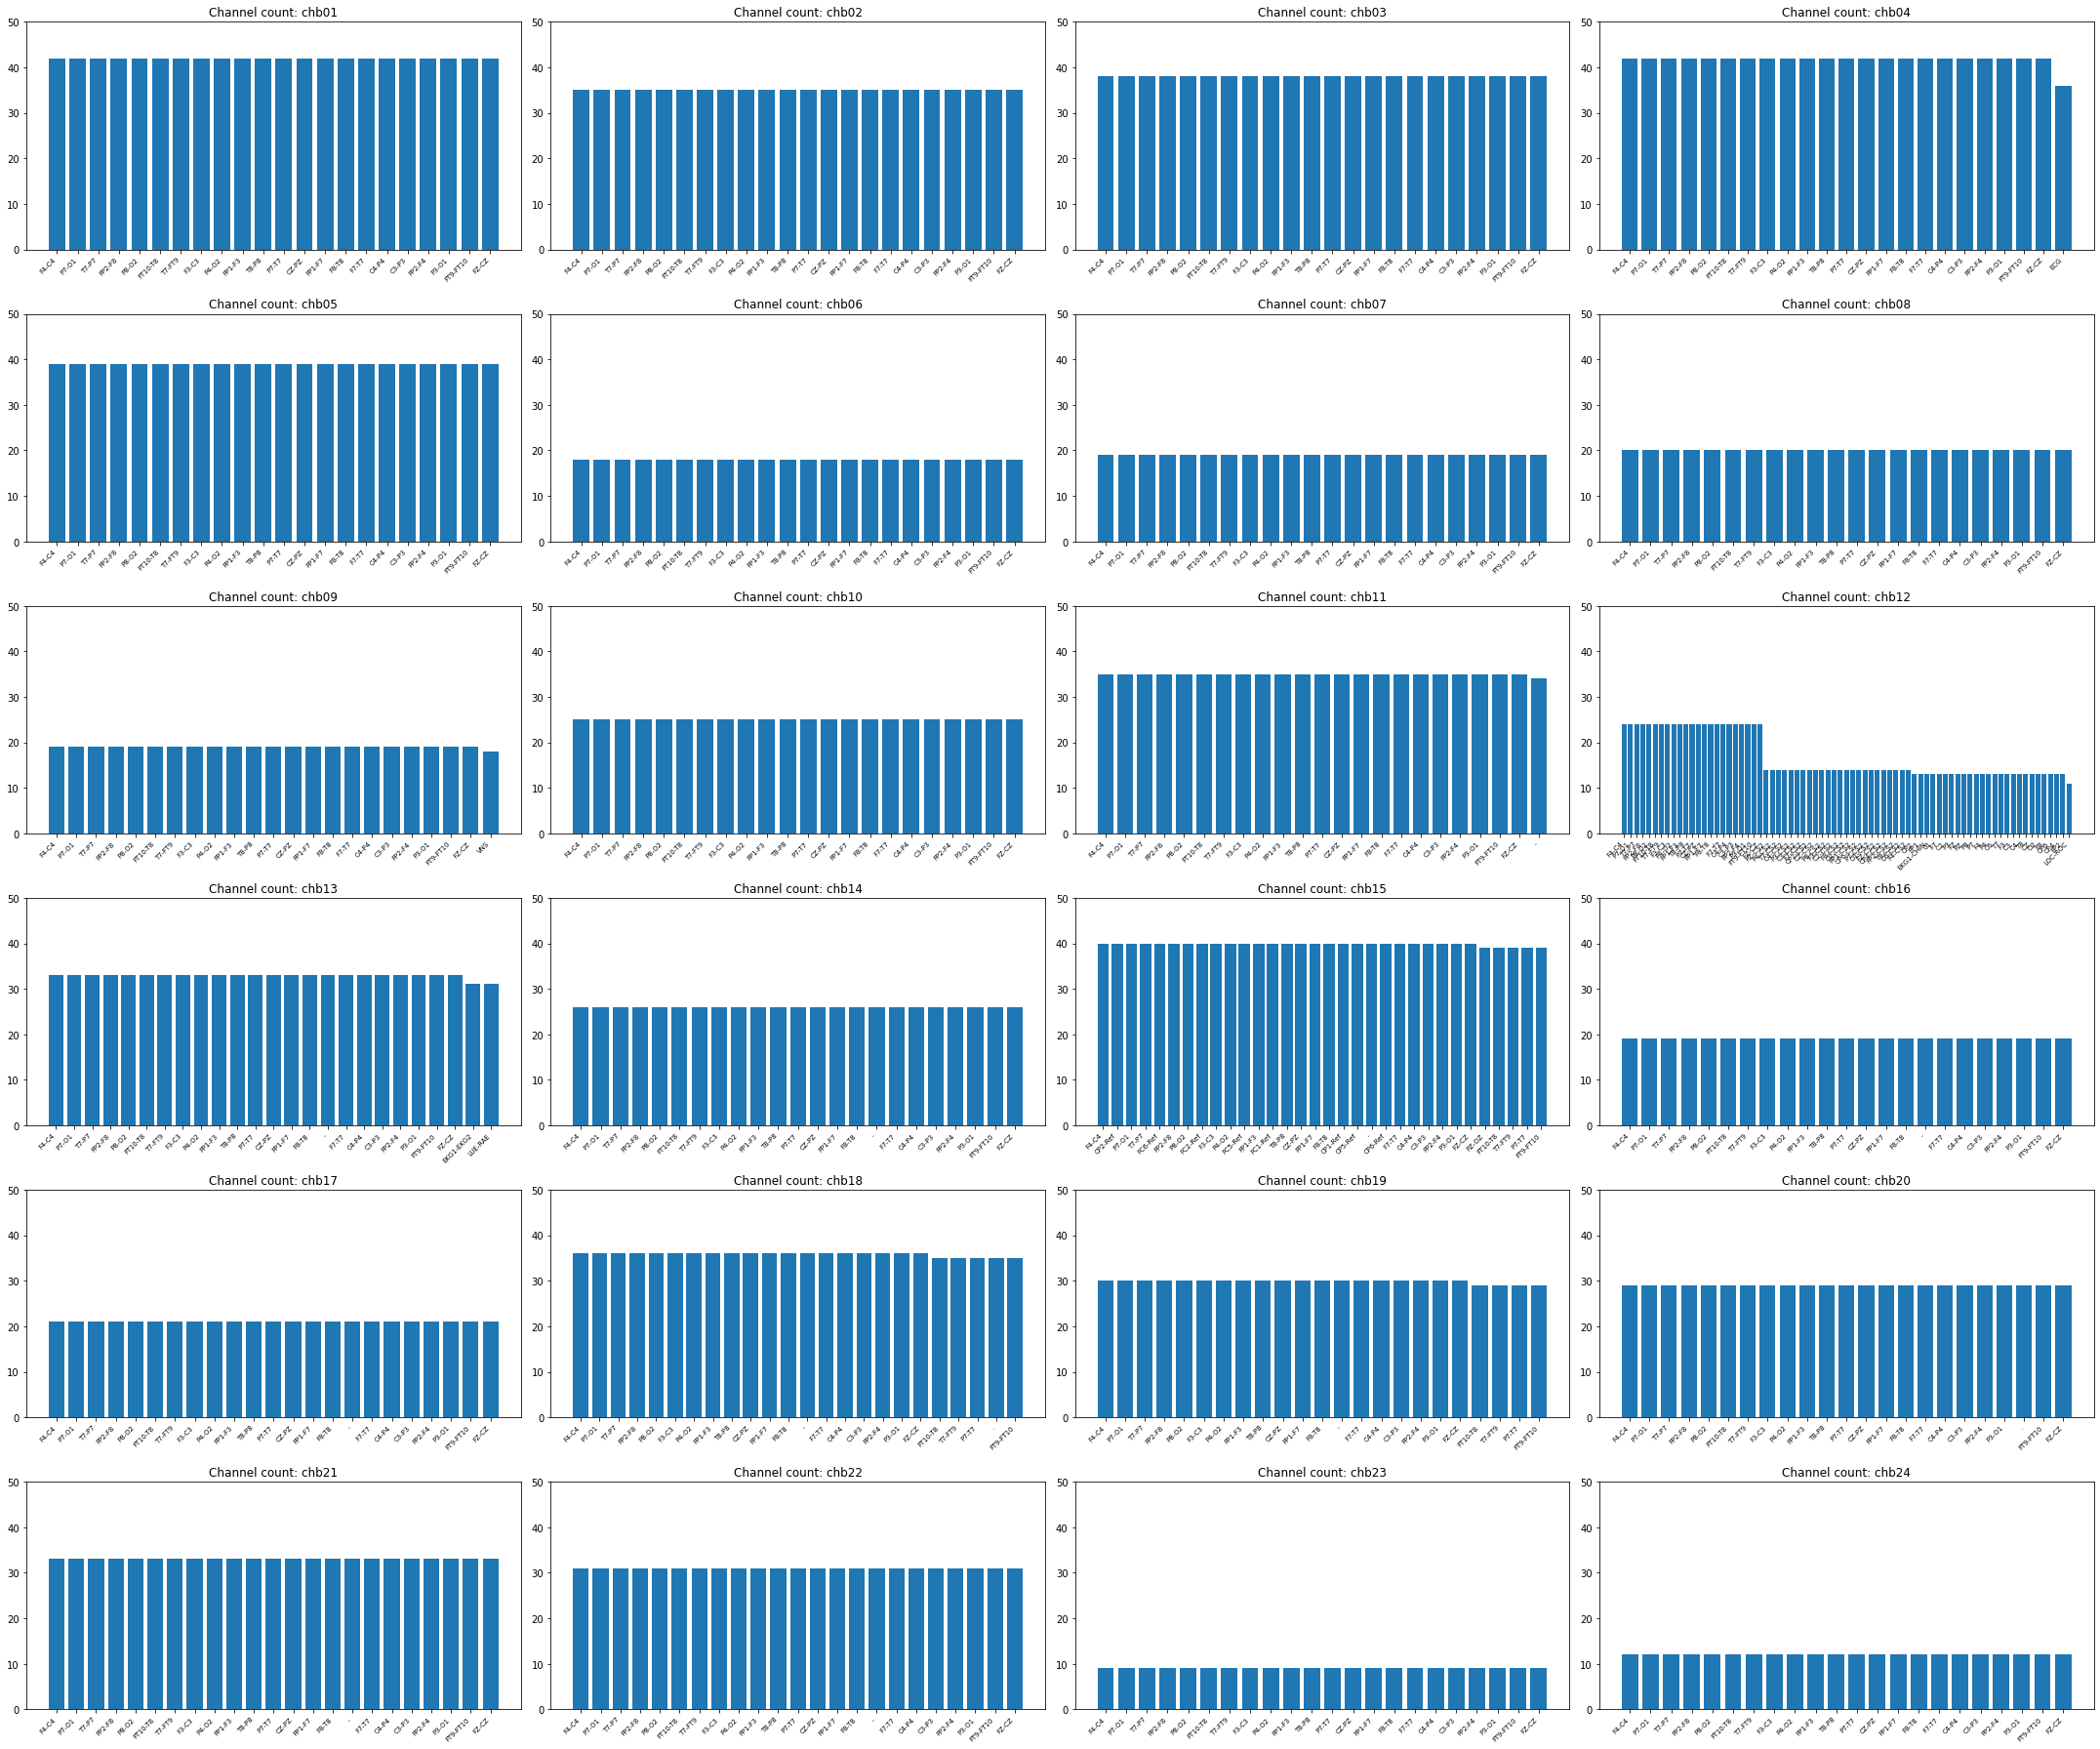

In [6]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(30,25))
for i, ax in enumerate(axes.flatten()):
    ax.bar(series_list[i].unique(), series_list[i].value_counts().values)
    ax.set_ylim([0, 50])
    ax.set_title(f"Channel count: {patient_codes[i]}")
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='x-small')
plt.tight_layout()
plt.savefig('figures/channel_count_distr.png')
plt.show()

In [7]:
pd.set_option('display.max_rows', None)

View channel names for chb12 as it contains significantly greater number of channels.

In [8]:
patient_idx = 11
content = get_content(patient_codes[patient_idx])
patient_info = parse_content(content)

channels = []
for part_name in patient_info.keys():
    channels.extend(patient_info[part_name]['Channels'])
    series = pd.Series(channels)
series.value_counts()   

FZ-CZ        24
C4-P4        24
-            24
F8-T8        24
FP1-F7       24
CZ-PZ        24
P7-T7        24
T8-P8        24
FT9-FT10     24
F3-C3        24
T7-FT9       24
C3-P3        24
FT10-T8      24
P8-O2        24
FP2-F8       24
T7-P7        24
P7-O1        24
F7-T7        24
FP1-F3       24
F4-C4        24
FP2-F4       24
P4-O2        24
P3-O1        24
FZ-CS2       14
F3-CS2       14
CZ-CS2       14
CP2-CS2      14
F7-CS2       14
T8-CS2       14
F8-CS2       14
P3-CS2       14
F4-CS2       14
C4-CS2       14
T7-CS2       14
P4-CS2       14
C3-CS2       14
PZ-CS2       14
C2-CS2       14
O1-CS2       14
CP4-CS2      14
CP6-CS2      14
C6-CS2       14
P8-CS2       14
O2-CS2       14
FP1-CS2      14
FP2-CS2      14
P7-CS2       14
FP2          13
CP2          13
CZ           13
P8           13
01           13
C4           13
F8           13
O2           13
T8           13
CP4          13
EKG1-CHIN    13
P7           13
FP1          13
C6           13
P4           13
F7      

Download first part of chb01 data.

In [9]:
file = records_list[0]
file

'chb01/chb01_01.edf'

In [10]:
# list of all channels in chb01
content = get_content(patient_codes[0])
patient_info = parse_content(content)
part_name = list(patient_info.keys())[0]
print(part_name)
print(patient_info[part_name].keys())
channels = patient_info[part_name]['Channels']

chb01_01
dict_keys(['Channels', 'Start Time', 'End Time', 'Seizures Window'])


In [11]:
file = records_list[0]
url = "https://physionet.org/physiobank/database/chbmit/" + file
filename = "data/chbmit.edf"
print("Requesting file:", url)
urlretrieve(url, filename)
print("Downloaded.")

Requesting file: https://physionet.org/physiobank/database/chbmit/chb01/chb01_01.edf
Downloaded.


In [12]:
f = pyedflib.EdfReader(filename)
# os.remove(filename) # delete from disk after loading into memory
selected_channel = 'CZ-PZ'
channels = f.getSignalLabels() # channel names
channel_freq = f.getSampleFrequencies() # vector of fs for each channel name
print(channels.index(selected_channel))
sig = f.readSignal(channels.index(selected_channel))

print(channels)
print(channel_freq)
print(sig.shape)
f.close()

17
['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8']
[256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256]
(921600,)


In [13]:
sig

array([84.59096459,  0.1953602 ,  0.1953602 , ..., 18.94993895,
       20.51282051, 18.16849817])

In [14]:
fs = channel_freq[channels.index(selected_channel)]
fs

256

Time domain signal representation.

Text(0, 0.5, 'Amplitude, $\\mu V$')

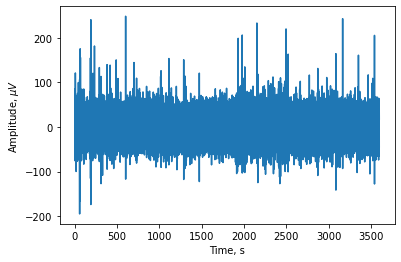

In [15]:
N = len(sig)
t = np.arange(0, N) / fs

fig, ax = plt.subplots()
ax.plot(t, sig)
ax.set_xlabel('Time, s')
ax.set_ylabel('Amplitude, $\mu V$')

Frequency domain signal representation.

7680


Text(0, 0.5, 'Frequency, Hz')

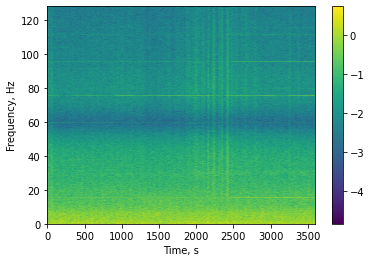

In [16]:
timewin = 30 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)
print(timewinidx)

f, t, Zxx = signal.stft(sig, fs=fs, window='hann',
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')

512


Text(0, 0.5, 'Frequency, Hz')

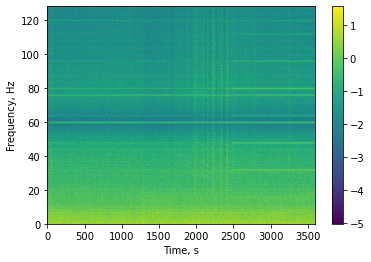

In [17]:
timewin = 2 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)
print(timewinidx)

f, t, Zxx = signal.stft(sig, fs=fs, window='hann',
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')

128000


Text(0, 0.5, 'Frequency, Hz')

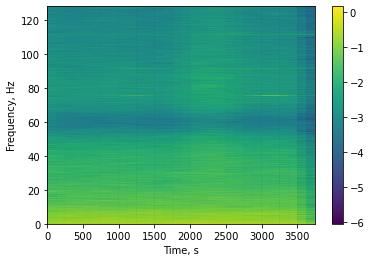

In [18]:
timewin = 500 # in seconds
timewinidx = np.round(timewin/(1/fs)).astype(int)
print(timewinidx)

f, t, Zxx = signal.stft(sig, fs=fs, window='hann',
                        nperseg=timewinidx, noverlap=None, nfft=None,
                        detrend='linear', return_onesided=True)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), shading='gouraud')
fig.colorbar(mesh)
ax.set_xlabel('Time, s')
ax.set_ylabel('Frequency, Hz')